<a href="https://colab.research.google.com/github/lililibin2022/Learning-Notes/blob/main/Train%20on%20YOLONAS_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src='https://raw.githubusercontent.com/Deci-AI/super-gradients/master/documentation/assets/SG_img/SG%20-%20Horizontal%20Glow%202.png'>

## 👋🏽 What's up! It's [Harpreet](https://twitter.com/DataScienceHarp)

I'll be guiding you through this notebook. At any point, if you get stuck or have questions, there are three ways to get in touch:

1) Send me an email with your issue: harpreet.sahota@deci.ai

2) Hop into the [Deep Learning Daily (powered by Deci) Discord server](https://discord.gg/p9ecgRhDR8), and let me know what your question is.

3) [Open an issue on GitHub](https://github.com/Deci-AI/super-gradients/issues/new/choose)


Let's get to it...

🚨 Note: after installation is complete (it make take a few minutes), you'll need to restart the runtime.

This is a known [issue](https://github.com/obss/sahi/discussions/781) that is on our roadmap.

In [1]:
%%capture
!pip install super-gradients==3.2.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

# 🦸🏾‍♂️ SuperGradients

SuperGradients is a PyTorch based training library.

It provides a uniform interface for the most common computer vision use cases:

- Classification

- Detection

- Segmentation

- Pose estimation

There are nearly 40 pretrained models in our model zoo. You can see the pretrained models available to you by following [this link](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/model_zoo.md).

This notebook will focus on using SuperGradients with YOLO-NAS. If you're interested in seeing how SG is used for image classification, you can check out [this templated notebook](https://colab.research.google.com/drive/1JYyEnEh2VdmKLxd7idUfBt6vLGOZxGIp?usp=sharing) that will make it easy to get started.

# 🫣 Sneak peek: Inference with YOLONAS

Before jumping into the section on fine-tuning, I wanted to show you the power of YOLONAS out of the box.

Start by instantiating a pretrained model. YOLONAS comes in three flavors: `yolo_nas_s`, `yolo_nas_m`, and `yolo_nas_l`.

You'll use `yolo_nas_l` throughout this notebook. Because you should always go big, or go home.

It's a good life philosophy.

In [2]:
from super_gradients.training import models

yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

[2023-09-05 09:04:31] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2023-09-05 09:04:34] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-09-05 09:04:39] INFO - utils.py - NumExpr defaulting to 8 threads.
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-09-05 09:04:40] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-09-05 09:04:40] WARNING - export.py - Failed to import pytorch_quantization
[2023-09-05 09:04:40] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-09-05 09:04:40] WARNING - env_sanity_check.py - Failed to verify installed packages: boto3 required but not found
[2023-09-05 09:04:40] WARNING - env_sanity_check.py - Failed to verify installed packages: deprecated required but not found
[2023-09-05 09:04:40] WARNING - env_sanity_check.py - Failed to verify installed packages: coverage required but not found
[2023-09-05 09:04:40] WARNING

You can run the following cell if you're interested in the architecture:

In [3]:
!pip install torchinfo
from torchinfo import summary

summary(model=yolo_nas_l,
        input_size=(16, 3, 640, 640),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNAS_L (YoloNAS_L)                                             [16, 3, 640, 640]    [16, 8400, 4]        --                   True
├─NStageBackbone (backbone)                                       [16, 3, 640, 640]    [16, 96, 160, 160]   --                   True
│    └─YoloNASStem (stem)                                         [16, 3, 640, 640]    [16, 48, 320, 320]   --                   True
│    │    └─QARepVGGBlock (conv)                                  [16, 3, 640, 640]    [16, 48, 320, 320]   3,024                True
│    └─YoloNASStage (stage1)                                      [16, 48, 320, 320]   [16, 96, 160, 160]   --                   True
│    │    └─QARepVGGBlock (downsample)                            [16, 48, 320, 320]   [16, 96, 160, 160]   88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

## 🖼️ Inference on an image

Once the model has been instantiated all you have to do is call the `predict` method.

This method operates on:
* PIL Image
* Numpy Image
* A path to image file
* A path to video file
* A path to folder with images
* URL (Image only)

Allowing you to perform inference with ease.

Note predict also has an argument called `conf`, which is the threshold for a detection. You change this value as you like, for example `model.predict("path/to/asset",conf=0.25)`

Let's perform inference on the following image:

<img src='https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg'>


[2023-09-05 09:06:05] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


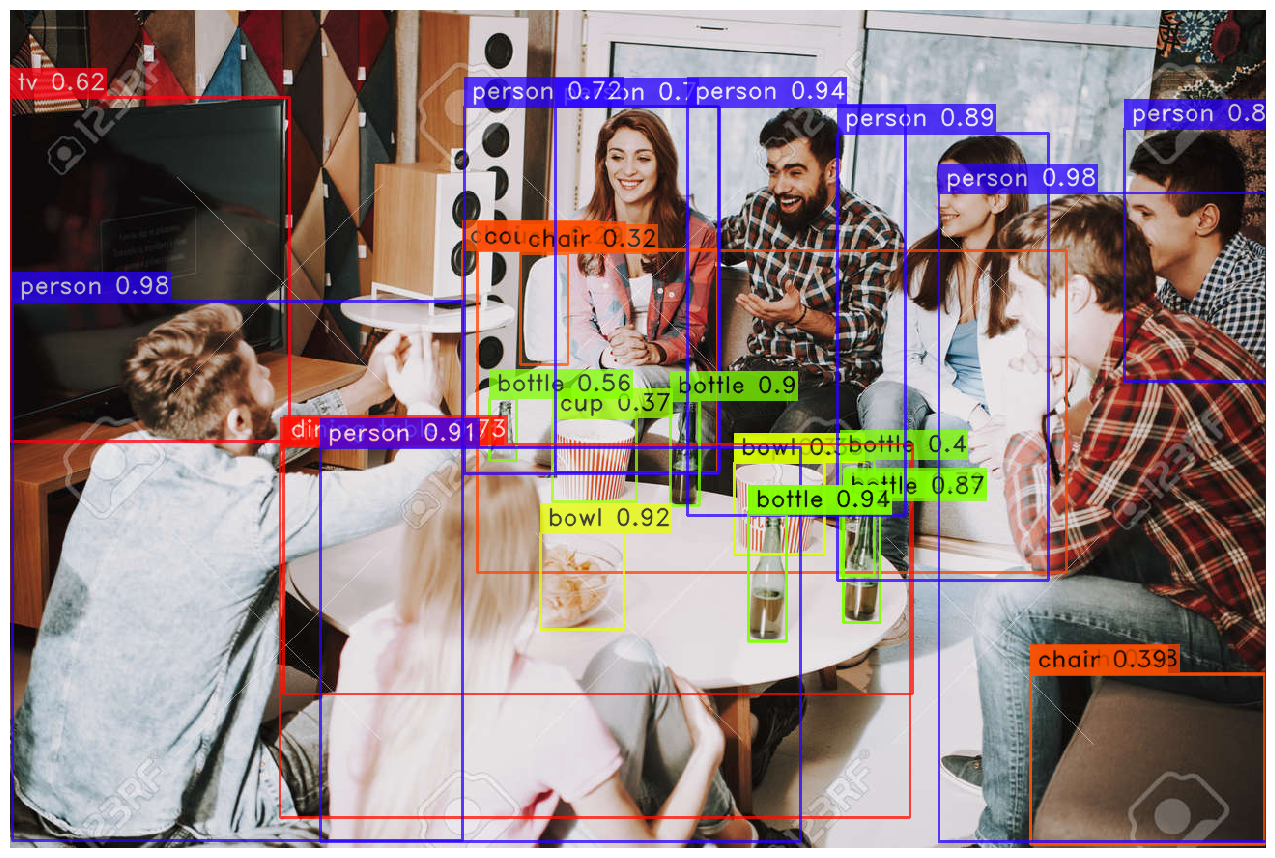

In [4]:
url = "https://previews.123rf.com/images/freeograph/freeograph2011/freeograph201100150/158301822-group-of-friends-gathering-around-table-at-home.jpg"
yolo_nas_l.predict(url, conf=0.25).show()

### 🤷🏽‍♂️ What's happening "under the hood"

1. Input image gets through the preprocessing pipeline, which includes image resizing, normalization and permute operation to convert input RGB image to torch tensor.
2. Model inference
3. Postprocessing of the detection results (Non-maximum suppression, resizing bounding boxes to the size of original image)
4. Visualization of the results (Rendering of bounding boxes on top of the image)

# 🎥 Inference on video

The following code will display and download stock footage video from YouTube.

[Here's a link](https://www.youtube.com/watch?v=4poqZjNTZjI&list=PLcKa-34z76PvI5KvI5S2JGj0RcBVuz3jg) to a playlist that has a lot of stock video clips which are 2mins in length or less.

### 🔎🤩 Find a video you like and use YOLONAS to perform some inference on it!

All you have to do is get the `video_id`, and replace the line `video_id = 'aE8I7bDf62M' ` in the cell below with your chosen video's id.

The `video_id` is everything that comes after `https://www.youtube.com/watch?v=`. For the video below, the full url was `https://www.youtube.com/watch?v=aE8I7bDf62M`, and thus the video id is `aE8I7bDf62M`.

After you've found a video and performed inference, don't forget to share it on Twitter or LinkedIn.

🏷️ And tag me in it so I don't miss it!

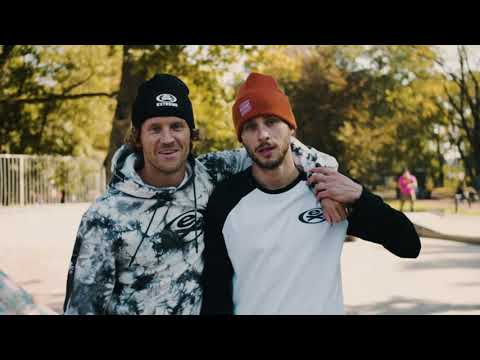

In [5]:
# Import the YouTubeVideo class from IPython.display
from IPython.display import YouTubeVideo

# Define the YouTube video ID
video_id = 'aE8I7bDf62M'  # Replace YOUR_VIDEO_ID with the actual video ID

# Create a YouTubeVideo object with the specified video ID
video = YouTubeVideo(video_id)

# Display the video
display(video)

In [6]:
%%capture

# Define the URL of the YouTube video
video_url = f'https://www.youtube.com/watch?v={video_id}'

# Download the video in mp4 format
!pip install -U "git+https://github.com/ytdl-org/youtube-dl.git"
!python -m youtube_dl -f 'bestvideo[ext=mp4]+bestaudio[ext=m4a]/mp4' "$video_url"

# Print a success message
print('Video downloaded successfully')

input_video_path = f"/content/EXTREME SPORTS X DIVERSE-{video_id}.mp4"
output_video_path = "detections.mp4"

### 📽️ Now, you'll peform inference on the video

Note, Google Colab is notorious for making it hard to display videos.

👀 Look to the left of the screen for the folder icon, it looks something like this: 🖿.

Click on that, and you'll see a file called `detections.mp4`.

Double click on that to download.

Google Colab is also notorious for taking a long time to download. You can continue on with the rest of the notebook while you wait.

If you have a work around for this, let me know!

In [7]:
import torch
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [8]:
yolo_nas_l.to(device).predict(input_video_path).save(output_video_path)

Predicting Video: 100%|██████████| 1137/1137 [00:27<00:00, 41.30it/s]


### 💻 Inference via webcam

Check [the documentation](https://github.com/Deci-AI/super-gradients/blob/505f646728249b9b35ea9060f34936f4e88234fd/src/super_gradients/examples/predict/detection_predict_streaming.py) for inference via webcam.

In [12]:
import torch
from super_gradients.common.object_names import Models
from super_gradients.training import models

In [14]:
# Note that currently only YoloX and PPYoloE are supported.
model = models.get(Models.YOLOX_N, pretrained_weights="coco")


[2023-09-05 09:11:56] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolox_n


In [15]:

# We want to use cuda if available to speed up inference.
model = model.to("cuda" if torch.cuda.is_available() else "cpu")



In [17]:
model.predict_webcam(0)

ValueError: ignored

In [19]:
import cv2

# Try to access the default webcam (usually index 0)
cap = cv2.VideoCapture(0)

# Check if the webcam is opened successfully
if not cap.isOpened():
    print("Webcam not available or could not be opened.")
else:
    # Retrieve webcam properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    print("Webcam is available and opened successfully.")
    print(f"Frame Width: {width}")
    print(f"Frame Height: {height}")
    print(f"Frames Per Second (FPS): {fps}")

    # Release the webcam
    cap.release()


Webcam not available or could not be opened.


# 🪡 Fine-tuning YOLONAS on custom dataset

## 🏋🏽 The trainer

The first thing you need to define in SuperGradients is the Trainer.

The trainer is in charge of training, evaluation, saving checkpoints, etc. If you're interested in seeing the source code for the trainer, you can do so [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/training/sg_trainer/sg_trainer.py).

### ✌🏼 There's two important arguments to the trainer:

1) `ckpt_root_dir` - this is the directory where results from all your experiments will be saved

2)`experiment_name` - all checkpoints, logs, and tensorboards will be saved in a directory with the name you specify here.

SuperGradients supports **Data Parallel** and **Distributed Data Parallel**.

That's outside of the scope for this introduction to SuperGradients. But, if you're fortunate enough to have multiple GPUs at your disposal or want learn more you can do so [here](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/device.md#3-dp---data-parallel).

In the code below, you'll instantiate the trainer with just a single GPU (since that's what Google Colab provides)

In [20]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

# 💾 Datasets and DataLoaders

Before you start, you need to create a Roboflow [account and get your API key](https://app.roboflow.com/login). If you're not sure how to find your API key, [here's how](https://www.loom.com/share/05277274e8d542efaf9bc3f33c1396d3?sid=3a41d4c5-c0c7-4712-bf4b-6a8c7ba51947).

SuperGradients is fully compatible with PyTorch Datasets and Dataloaders, so you can use your dataloaders as is.

There are several well-known datasets for object detection, for example:

- COCO
- Pascal
- YOLODarkNet
- YOLOv5

SuperGradients provides ready-to-use dataloaders for these datasets. If you're interested in learning more about working with `COCOFormatDetectionDataset` and the more general `DetectionDataset` [check out the SuperGradients documentation on this topic](https://docs.deci.ai/super-gradients/docstring/training/datasets/#training.datasets.detection_datasets.coco_detection.COCODetectionDataset)

You can learn more about working with SuperGradients datasets, dataloaders, and configuration files [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Data.md)

SuperGradients supports a number of dataset formats, you can learn more about that [here.](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/ObjectDetection.md)

For this example you'll use the the [U.S. Coins Dataset](https://universe.roboflow.com/atathamuscoinsdataset/u.s.-coins-dataset-a.tatham/dataset/5) from [RoboFlow](https://app.roboflow.com/login) with the dataset in YOLOv5 format.

## Some datasets you might want to try:
 - [HuggingFace competition: Ship detection](https://huggingface.co/spaces/competitions/ship-detection)

- [Aquarium dataset on RoboFlow](https://public.roboflow.com/object-detection/aquarium)

- [Vehicles-OpenImages Dataset on RoboFlow](https://public.roboflow.com/object-detection/vehicles-openimages)

- [Winegrape detection](https://github.com/thsant/wgisd)

- [Low light object detection](https://github.com/cs-chan/Exclusively-Dark-Image-Dataset)

- [Infrafred person detection](https://camel.ece.gatech.edu/)

- [Pothole detection](https://www.kaggle.com/datasets/chitholian/annotated-potholes-dataset)

- [100k Labeled Road Images | Day, Night](https://www.kaggle.com/datasets/solesensei/solesensei_bdd100k)

- [Deep Fashion dataset](https://github.com/switchablenorms/DeepFashion2)

- [Playing card detection](https://www.kaggle.com/datasets/luantm/playing-card)

- [Anaomoly detection in videos](https://www.crcv.ucf.edu/projects/real-world/)

- [Underwater fish recognition](https://www.kaggle.com/datasets/aalborguniversity/brackish-dataset)

- [Document layout detection](https://www.primaresearch.org/datasets/Layout_Analysis)

- [Trash Annotations in Context](http://tacodataset.org/)

In [21]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="KambJHvvNRVwsQ1xhopi")
project = rf.workspace("fafu").project("ccha_detector")
dataset = project.version(4).download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to CCHA_detector-4 in yolov5pytorch:: 100%|██████████| 11660/11660 [00:00<00:00, 11731.46it/s]


Start by importing the required modules, which will help you create SuperGradients dataloaders.


In [22]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

You'll need to load your dataset parameters into a dictionary, specifically defining:

- path to the parent directory where your data lives
- the child directory names for training, validation, and test (if you have testing set) images and labels
- class names

In [23]:
dataset_params = {
    'data_dir':'/content/CCHA_detector-4',
    'train_images_dir':'train/images',
    'train_labels_dir':'train/labels',
    'val_images_dir':'valid/images',
    'val_labels_dir':'valid/labels',
    'test_images_dir':'test/images',
    'test_labels_dir':'test/labels',
    'classes': ['CC', 'HA']
}

You pass the values for `dataset_params` into the `dataset_params` argument as shown below.

You can also pass PyTorch DataLoaders arguments when instantiating your dataset. Here you'll set `batch_size=16` and `num_workers=2`.

Repeat this for the validation and testing datasets, note that for training and testing data we use `coco_detection_yolo_format_val` to instantiate the dataloader.

The dataloaders will print warnings when an annotation does not conform to the expected format. This particular dataset has many such annotations, thus the warnings will be muted.

In [24]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

clear_output()

### 🧐 Now inspect the dataset defined earlier.

SuperGradients added `transforms` for you. You're free to experiment with these transformations as you please. You can also add in your own transformations from `torchvision.transforms` or a custom tranformaton.

In [25]:
train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': (640, 640), 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': (640, 640), 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': (640, 640), 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5),
 DetectionPaddedRescale('additional_samples_count': 0, 'non_em

You can plot a batch of training data with their augmentations applied to see what they look like:

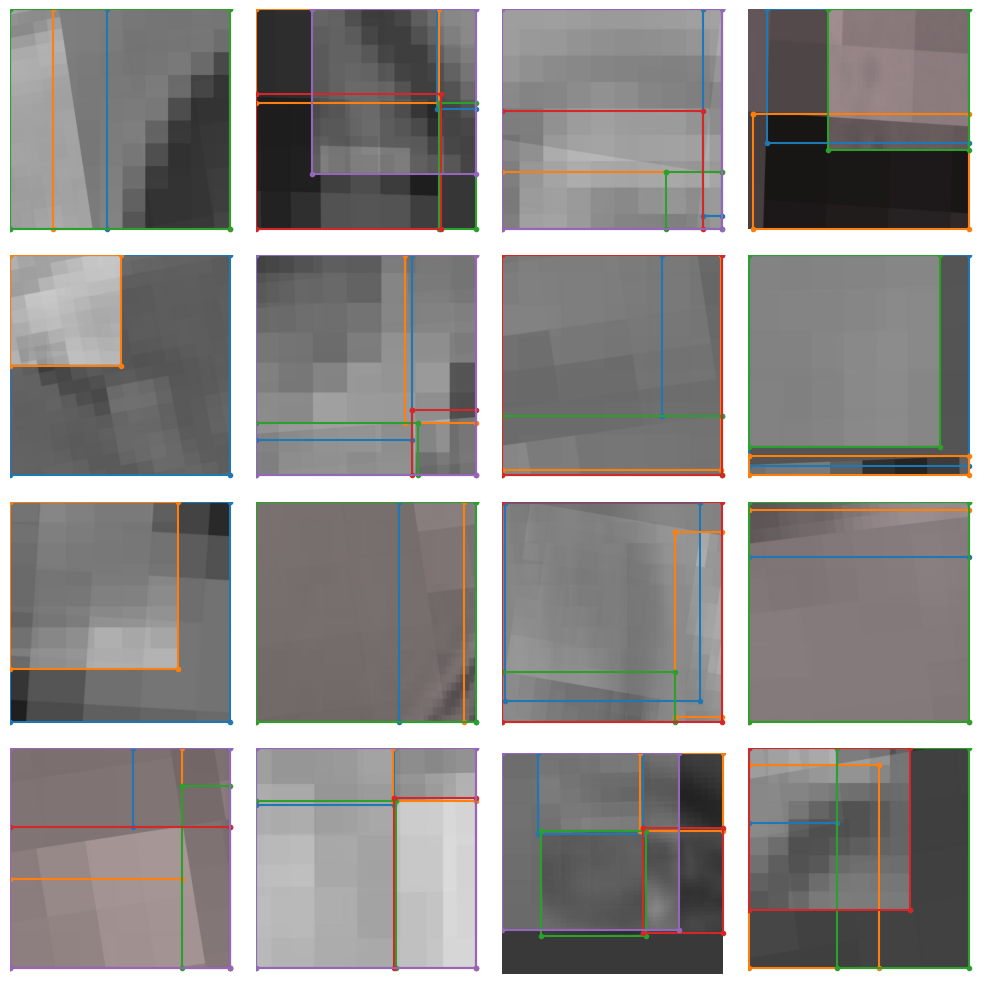

In [36]:
train_data.dataset.plot()

# 👩🏽‍🦳 Instantiating the model

You saw how to instantiate the model for inference earlier.

Below is how to instantiate the model for finetuning. Note you need to add the `num_classes` argument here.

Note, for this tutorial you're using `yolo_nas_l`, but SuperGradients has two other flavors of YOLONAS available to you: `yolo_nas_s` and `yolo_nas_m`.

In [29]:
from super_gradients.training import models
model = models.get('yolo_nas_l',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2023-09-05 09:21:00] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-09-05 09:21:00] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l


# 🎛️ Training parameters

You need to define the training parameters for your training run.

Full details about the training parameters can be found [here](https://github.com/Deci-AI/super-gradients/blob/master/src/super_gradients/recipes/training_hyperparams/default_train_params.yaml).


### 🚨 There are a few **mandatory** arguments that you must define for training params 🚨

- `max_epochs` - Max number of training epochs

- `loss` - the loss function you want to use

- `optimizer` - Optimizer you will be using

- `train_metrics_list` - Metrics to log during training

- `valid_metrics_list` - Metrics to log during training

- `metric_to_watch` - metric which the model checkpoint will be saved according to

You can choose from a variety of `optimizer`'s such as: Adam, AdamW, SGD, Lion, or RMSProps. If you choose to change the defualt parameters of these optimizrs you pass them into `optimizer_params`.


### 🧑🏾‍🔬 Integrations with experiment monitoring tools

SuperGradients has native integrations with Tensorboard, Weights and Biases, ClearML, and DagsHub.

If your favorite monitoring tool is not supported by SuperGradients, you can simply implement a class inheriting from BaseSGLogger that you will then pass to the training parameters.

If you're interested in monitoring experiments, you can learn more [in the docs](https://github.com/Deci-AI/super-gradients/blob/0fe46cd39572db34eb83d68e343fed97b8886fe9/documentation/source/experiment_monitoring.md).


### 🪄 SuperGradients offers a number of training tricks right out of the box, such as:

- Exponential moving average
- Zero weight decay on bias and batch normalizatiom
- Weight averaging
- Batch accumulation
- Precise BatchNorm

You can read more details about these training tricks [here](https://heartbeat.comet.ml/a-better-way-to-train-your-neural-networks-813b60a5bd6a).

If you're interested in building a using a custom metric with SuperGradients you can learn how [here](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/Metrics.md).

Note you will have to set number of classes in two places below: `PPYoloELoss` and `DetectionMetrics_050`.

You probably noticed that we make use of a post prediction callback, for details on how phase callbacks work in SuperGradients [check out our documentation](https://github.com/Deci-AI/super-gradients/blob/master/documentation/source/PhaseCallbacks.md).

### 🔕 Note: I've enabled `silent_mode` so the notebook doesn't get longer than it already is. You should disable it so you can see what SuperGradients outputs during training.

In [30]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# 🦾 Training the model

You've covered a lot of ground so far:

✅ Instantiated the trainer

✅ Defined your dataset parameters and dataloaders

✅ Instantiated a model

✅ Set up your training parameters

### ⏳ Now, its time to train a model

Training a model using a SuperGradients is done using the `trainer`.

It's as easy as...

In [31]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

The console stream is now moved to checkpoints/my_first_yolonas_run/console_Sep05_09_22_08.txt


[2023-09-05 09:22:08] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
[2023-09-05 09:22:10] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 4324       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         270        (len(train_loader))
    - Gradient updates per epoch:   270        (len(train_loader) / batch_accumulate)

[2023-09-05 09:22:10] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validating: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 09:27:34] INFO - base_sg_logger.py -

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 2.2669
│   ├── Ppyoloeloss/loss_iou = 0.1543
│   ├── Ppyoloeloss/loss_dfl = 1.2745
│   └── Ppyoloeloss/loss = 3.29
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.2116
    ├── Ppyoloeloss/loss_iou = 0.0599
    ├── Ppyoloeloss/loss_dfl = 0.9278
    ├── Ppyoloeloss/loss = 1.8253
    ├── Precision@0.50 = 0.3043
    ├── Recall@0.50 = 0.8912
    ├── Map@0.50 = 0.5571
    └── F1@0.50 = 0.4532



Validating epoch 1: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 09:32:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 09:32:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8112142086029053


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.0394
│   │   ├── Epoch N-1      = 2.2669 (↘ -1.2276)
│   │   └── Best until now = 2.2669 (↘ -1.2276)
│   ├── Ppyoloeloss/loss_iou = 0.0843
│   │   ├── Epoch N-1      = 0.1543 (↘ -0.07)
│   │   └── Best until now = 0.1543 (↘ -0.07)
│   ├── Ppyoloeloss/loss_dfl = 0.961
│   │   ├── Epoch N-1      = 1.2745 (↘ -0.3135)
│   │   └── Best until now = 1.2745 (↘ -0.3135)
│   └── Ppyoloeloss/loss = 1.7306
│       ├── Epoch N-1      = 3.29   (↘ -1.5594)
│       └── Best until now = 3.29   (↘ -1.5594)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8117
    │   ├── Epoch N-1      = 1.2116 (↘ -0.3999)
    │   └── Best until now = 1.2116 (↘ -0.3999)
    ├── Ppyoloeloss/loss_iou = 0.006
    │   ├── Epoch N-1      = 0.0599 (↘ -0.054)
    │   └── Best until now = 0.0599 (↘ -0.054)
    ├── Ppyoloeloss/loss_dfl = 0.7153
    │   ├── Epoch N-1      = 0.9278 (↘ -0.2125)
    │   └── Best until now = 0.9278 (↘ -0.2125)
    ├── Ppyoloeloss/loss = 1.1

Validating epoch 2: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.9444
│   │   ├── Epoch N-1      = 1.0394 (↘ -0.095)
│   │   └── Best until now = 1.0394 (↘ -0.095)
│   ├── Ppyoloeloss/loss_iou = 0.0692
│   │   ├── Epoch N-1      = 0.0843 (↘ -0.0151)
│   │   └── Best until now = 0.0843 (↘ -0.0151)
│   ├── Ppyoloeloss/loss_dfl = 0.8777
│   │   ├── Epoch N-1      = 0.961  (↘ -0.0833)
│   │   └── Best until now = 0.961  (↘ -0.0833)
│   └── Ppyoloeloss/loss = 1.5564
│       ├── Epoch N-1      = 1.7306 (↘ -0.1743)
│       └── Best until now = 1.7306 (↘ -0.1743)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7377
    │   ├── Epoch N-1      = 0.8117 (↘ -0.074)
    │   └── Best until now = 0.8117 (↘ -0.074)
    ├── Ppyoloeloss/loss_iou = 0.0032
    │   ├── Epoch N-1      = 0.006  (↘ -0.0027)
    │   └── Best until now = 0.006  (↘ -0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.7018
    │   ├── Epoch N-1      = 0.7153 (↘ -0.0135)
    │   └── Best until now = 0.7153 (↘ -0.0135)
    ├── Ppyoloeloss/loss =

Validating epoch 3: 100%|██████████| 62/62 [00:39<00:00,  1.55it/s]


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8931
│   │   ├── Epoch N-1      = 0.9444 (↘ -0.0513)
│   │   └── Best until now = 0.9444 (↘ -0.0513)
│   ├── Ppyoloeloss/loss_iou = 0.063
│   │   ├── Epoch N-1      = 0.0692 (↘ -0.0062)
│   │   └── Best until now = 0.0692 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_dfl = 0.8379
│   │   ├── Epoch N-1      = 0.8777 (↘ -0.0398)
│   │   └── Best until now = 0.8777 (↘ -0.0398)
│   └── Ppyoloeloss/loss = 1.4696
│       ├── Epoch N-1      = 1.5564 (↘ -0.0868)
│       └── Best until now = 1.5564 (↘ -0.0868)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.8099
    │   ├── Epoch N-1      = 0.7377 (↗ 0.0723)
    │   └── Best until now = 0.7377 (↗ 0.0723)
    ├── Ppyoloeloss/loss_iou = 0.0047
    │   ├── Epoch N-1      = 0.0032 (↗ 0.0015)
    │   └── Best until now = 0.0032 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.7102
    │   ├── Epoch N-1      = 0.7018 (↗ 0.0084)
    │   └── Best until now = 0.7018 (↗ 0.0084)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 4: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 09:48:50] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 09:48:50] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8224977254867554


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8472
│   │   ├── Epoch N-1      = 0.8931 (↘ -0.0459)
│   │   └── Best until now = 0.8931 (↘ -0.0459)
│   ├── Ppyoloeloss/loss_iou = 0.0518
│   │   ├── Epoch N-1      = 0.063  (↘ -0.0112)
│   │   └── Best until now = 0.063  (↘ -0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.7857
│   │   ├── Epoch N-1      = 0.8379 (↘ -0.0523)
│   │   └── Best until now = 0.8379 (↘ -0.0523)
│   └── Ppyoloeloss/loss = 1.3696
│       ├── Epoch N-1      = 1.4696 (↘ -0.1)
│       └── Best until now = 1.4696 (↘ -0.1)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6234
    │   ├── Epoch N-1      = 0.8099 (↘ -0.1865)
    │   └── Best until now = 0.7377 (↘ -0.1143)
    ├── Ppyoloeloss/loss_iou = 0.0021
    │   ├── Epoch N-1      = 0.0047 (↘ -0.0027)
    │   └── Best until now = 0.0032 (↘ -0.0012)
    ├── Ppyoloeloss/loss_dfl = 0.6985
    │   ├── Epoch N-1      = 0.7102 (↘ -0.0117)
    │   └── Best until now = 0.7018 (↘ -0.0033)
    ├── Ppyoloeloss/loss = 0

Validating epoch 5: 100%|██████████| 62/62 [00:39<00:00,  1.55it/s]
[2023-09-05 09:54:13] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 09:54:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8406549096107483


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8084
│   │   ├── Epoch N-1      = 0.8472 (↘ -0.0388)
│   │   └── Best until now = 0.8472 (↘ -0.0388)
│   ├── Ppyoloeloss/loss_iou = 0.045
│   │   ├── Epoch N-1      = 0.0518 (↘ -0.0068)
│   │   └── Best until now = 0.0518 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.7543
│   │   ├── Epoch N-1      = 0.7857 (↘ -0.0314)
│   │   └── Best until now = 0.7857 (↘ -0.0314)
│   └── Ppyoloeloss/loss = 1.2982
│       ├── Epoch N-1      = 1.3696 (↘ -0.0715)
│       └── Best until now = 1.3696 (↘ -0.0715)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7646
    │   ├── Epoch N-1      = 0.6234 (↗ 0.1413)
    │   └── Best until now = 0.6234 (↗ 0.1413)
    ├── Ppyoloeloss/loss_iou = 0.0023
    │   ├── Epoch N-1      = 0.0021 (↗ 0.0003)
    │   └── Best until now = 0.0021 (↗ 0.0003)
    ├── Ppyoloeloss/loss_dfl = 0.6998
    │   ├── Epoch N-1      = 0.6985 (↗ 0.0013)
    │   └── Best until now = 0.6985 (↗ 0.0013)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 6: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7759
│   │   ├── Epoch N-1      = 0.8084 (↘ -0.0325)
│   │   └── Best until now = 0.8084 (↘ -0.0325)
│   ├── Ppyoloeloss/loss_iou = 0.0387
│   │   ├── Epoch N-1      = 0.045  (↘ -0.0063)
│   │   └── Best until now = 0.045  (↘ -0.0063)
│   ├── Ppyoloeloss/loss_dfl = 0.7277
│   │   ├── Epoch N-1      = 0.7543 (↘ -0.0266)
│   │   └── Best until now = 0.7543 (↘ -0.0266)
│   └── Ppyoloeloss/loss = 1.2365
│       ├── Epoch N-1      = 1.2982 (↘ -0.0617)
│       └── Best until now = 1.2982 (↘ -0.0617)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.634
    │   ├── Epoch N-1      = 0.7646 (↘ -0.1307)
    │   └── Best until now = 0.6234 (↗ 0.0106)
    ├── Ppyoloeloss/loss_iou = 0.0019
    │   ├── Epoch N-1      = 0.0023 (↘ -0.0004)
    │   └── Best until now = 0.0021 (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.6988
    │   ├── Epoch N-1      = 0.6998 (↘ -0.001)
    │   └── Best until now = 0.6985 (↗ 0.0003)
    ├── Ppyoloeloss/loss = 

Validating epoch 7: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 10:05:02] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 10:05:02] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8567817211151123


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7475
│   │   ├── Epoch N-1      = 0.7759 (↘ -0.0283)
│   │   └── Best until now = 0.7759 (↘ -0.0283)
│   ├── Ppyoloeloss/loss_iou = 0.0323
│   │   ├── Epoch N-1      = 0.0387 (↘ -0.0064)
│   │   └── Best until now = 0.0387 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_dfl = 0.6995
│   │   ├── Epoch N-1      = 0.7277 (↘ -0.0282)
│   │   └── Best until now = 0.7277 (↘ -0.0282)
│   └── Ppyoloeloss/loss = 1.1781
│       ├── Epoch N-1      = 1.2365 (↘ -0.0584)
│       └── Best until now = 1.2365 (↘ -0.0584)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5697
    │   ├── Epoch N-1      = 0.634  (↘ -0.0643)
    │   └── Best until now = 0.6234 (↘ -0.0537)
    ├── Ppyoloeloss/loss_iou = 0.001
    │   ├── Epoch N-1      = 0.0019 (↘ -0.001)
    │   └── Best until now = 0.0019 (↘ -0.001)
    ├── Ppyoloeloss/loss_dfl = 0.6967
    │   ├── Epoch N-1      = 0.6988 (↘ -0.0021)
    │   └── Best until now = 0.6985 (↘ -0.0018)
    ├── Ppyoloeloss/loss 

Validating epoch 8: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 10:10:29] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 10:10:29] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8703337907791138


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7281
│   │   ├── Epoch N-1      = 0.7475 (↘ -0.0194)
│   │   └── Best until now = 0.7475 (↘ -0.0194)
│   ├── Ppyoloeloss/loss_iou = 0.0281
│   │   ├── Epoch N-1      = 0.0323 (↘ -0.0042)
│   │   └── Best until now = 0.0323 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.6862
│   │   ├── Epoch N-1      = 0.6995 (↘ -0.0133)
│   │   └── Best until now = 0.6995 (↘ -0.0133)
│   └── Ppyoloeloss/loss = 1.1413
│       ├── Epoch N-1      = 1.1781 (↘ -0.0367)
│       └── Best until now = 1.1781 (↘ -0.0367)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5752
    │   ├── Epoch N-1      = 0.5697 (↗ 0.0055)
    │   └── Best until now = 0.5697 (↗ 0.0055)
    ├── Ppyoloeloss/loss_iou = 0.0009
    │   ├── Epoch N-1      = 0.001  (↘ -1e-04)
    │   └── Best until now = 0.001  (↘ -1e-04)
    ├── Ppyoloeloss/loss_dfl = 0.6962
    │   ├── Epoch N-1      = 0.6967 (↘ -0.0004)
    │   └── Best until now = 0.6967 (↘ -0.0004)
    ├── Ppyoloeloss/loss =

Validating epoch 9: 100%|██████████| 62/62 [00:40<00:00,  1.55it/s]
[2023-09-05 10:15:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/my_first_yolonas_run/ckpt_best.pth
[2023-09-05 10:15:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.8773245811462402


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7121
│   │   ├── Epoch N-1      = 0.7281 (↘ -0.016)
│   │   └── Best until now = 0.7281 (↘ -0.016)
│   ├── Ppyoloeloss/loss_iou = 0.0255
│   │   ├── Epoch N-1      = 0.0281 (↘ -0.0025)
│   │   └── Best until now = 0.0281 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.676
│   │   ├── Epoch N-1      = 0.6862 (↘ -0.0102)
│   │   └── Best until now = 0.6862 (↘ -0.0102)
│   └── Ppyoloeloss/loss = 1.1139
│       ├── Epoch N-1      = 1.1413 (↘ -0.0274)
│       └── Best until now = 1.1413 (↘ -0.0274)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.5744
    │   ├── Epoch N-1      = 0.5752 (↘ -0.0008)
    │   └── Best until now = 0.5697 (↗ 0.0047)
    ├── Ppyoloeloss/loss_iou = 0.0006
    │   ├── Epoch N-1      = 0.0009 (↘ -0.0002)
    │   └── Best until now = 0.0009 (↘ -0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.6952
    │   ├── Epoch N-1      = 0.6962 (↘ -0.001)
    │   └── Best until now = 0.6962 (↘ -0.001)
    ├── Ppyoloeloss/loss = 0

[2023-09-05 10:16:12] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 10: 100%|██████████| 62/62 [00:40<00:00,  1.53it/s]


# 🏆 Get the best trained model

Now that training is complete, you need to get the best trained model.

You used checkpoint averaging so the following code will use weights averaged across training runs.

If you want to use the best weights, or weights from the last epoch you'd use one of the following in the code below:

- best weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_best.pth`

- last weights: `checkpoint_path = checkpoints/my_first_yolonas_run/ckpt_latest.pth`

In [32]:
best_model = models.get('yolo_nas_l',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path="checkpoints/my_first_yolonas_run/average_model.pth")

[2023-09-05 10:36:51] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/my_first_yolonas_run/average_model.pth EMA checkpoint.


# 🧐 Evaluating the best trained model on the test set

In [33]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1,
                                                   top_k_predictions=300,
                                                   num_cls=len(dataset_params['classes']),
                                                   normalize_targets=True,
                                                   post_prediction_callback=PPYoloEPostPredictionCallback(score_threshold=0.01,
                                                                                                          nms_top_k=1000,
                                                                                                          max_predictions=300,
                                                                                                          nms_threshold=0.7)
                                                  ))

Testing: 100%|██████████| 33/33 [00:23<00:00,  1.83it/s]

{'PPYoloELoss/loss_cls': 0.65973634,
 'PPYoloELoss/loss_iou': 0.00076470413,
 'PPYoloELoss/loss_dfl': 0.6961788,
 'PPYoloELoss/loss': 1.0097375,
 'Precision@0.50': 0.10042033344507217,
 'Recall@0.50': 1.0,
 'mAP@0.50': 0.8465957641601562,
 'F1@0.50': 0.18240687251091003}

# 🔮 Predicting with the best model

The next line will perform detection on the following image. Note, we didn't have a class for the half dollar coin. So it will likely get classified as something else.

<img src='https://www.mynumi.net/media/catalog/product/cache/2/image/9df78eab33525d08d6e5fb8d27136e95/s/e/serietta_usa_2_1/www.mynumi.net-USASE5AD160-31.jpg'>

The results aren't too bad after just a few epochs!





[2023-09-05 10:40:43] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


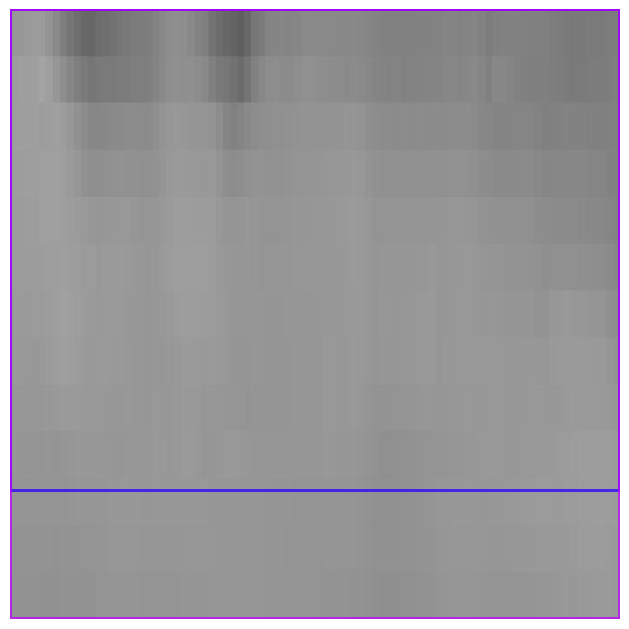

In [35]:
img_url = '/content/CCHA_detector-4/test/images/11_009_jpg.rf.7239cca4ca0e241c1e8e952ce0bd3afa.jpg'
best_model.predict(img_url).show()

# Post training quantization (PTQ) and quantization aware training (QAT)

SuperGradients offers PTQ and QAT out of the box. That's beyond the scope of this introductory tutorial. It is, in my opinion, a truly awesome feature.

Not many training libaries offer this out of the box.  You can learn more about PTQ and QAT [here](https://github.com/Deci-AI/super-gradients/blob/c339e2619616878172c060e6491c8c2129ed3fd4/documentation/source/ptq_qat.md).

An example specific to YOLONAS can be found [here](https://github.com/Deci-AI/super-gradients/blob/feature/SG-736_deci_yolo_rf100/documentation/source/qat_ptq_yolo_nas.md).

# 💫 I think you're ready to venture out on your own now!

I've created a templated notebook for you [here](https://colab.research.google.com/drive/10N6NmSMCiRnFlKV9kaIS_z3pk0OI1xKC?usp=sharing).

If you run into any issues, you know how to get a hold of me (contact info is at the top of the notebook).

Cheers and I can't wait to see what you come up with!